In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e4/sample_submission.csv
/kaggle/input/playground-series-s5e4/train.csv
/kaggle/input/playground-series-s5e4/test.csv


In [2]:
def show(df, n_rows=5, sort=None):
    if n_rows == 'all':
        if sort is not None:
            df = df.sort_values(sort, ascending=False)
        display(df.head(df.shape[0]))
        print(f"{df.shape[0]} rows x {df.shape[1]} columns")
    else:
        if sort:
            df = df.sort_values(sort, ascending=False)
        display(df.head(n_rows))
        print(f"{df.shape[0]} rows x {df.shape[1]} columns")

In [3]:
global device

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    device = 'gpu'
else:
    print("GPU is not available")
    device = 'cpu'

GPU is not available


In [4]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
show(train_df)

test_df = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")
show(test_df)

submission=pd.read_csv("/kaggle/input/playground-series-s5e4/sample_submission.csv")
show(submission)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


750000 rows x 12 columns


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


250000 rows x 11 columns


,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


250000 rows x 2 columns


In [5]:
columns_name_mapping = {col: str.lower(col) for col in train_df.columns}

train_df = train_df.rename(columns=columns_name_mapping)
test_df = test_df.rename(columns=columns_name_mapping)

show(train_df)
show(test_df)

,id,podcast_name,episode_title,episode_length_minutes,genre,host_popularity_percentage,publication_day,publication_time,guest_popularity_percentage,number_of_ads,episode_sentiment,listening_time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


750000 rows x 12 columns


,id,podcast_name,episode_title,episode_length_minutes,genre,host_popularity_percentage,publication_day,publication_time,guest_popularity_percentage,number_of_ads,episode_sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


250000 rows x 11 columns


In [6]:
target = 'listening_time_minutes'

train_copy = train_df.copy()
test_copy = test_df.copy()

# EDA

## Check missing values

In [7]:
out_cols = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %', "Discrete Ratio (Train)"]
out = []

for col in train_copy.columns:

    if col in [target, 'id']:
        continue
    
    data_type = train_copy[col].dtype

    train_missing_share = round(train_copy[col].isna().sum() / train_copy.shape[0], 2)

    test_missing_share = round(test_copy[col].isna().sum() / test_copy.shape[0], 2)

    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = round(train_copy[col].nunique() / train_copy.shape[0], 3)

    out.append([col, data_type, train_missing_share, test_missing_share, discrete_ratio])

table = pd.DataFrame.from_records(out, columns = out_cols)

show(table, 20)

,Feature,Data Type,Train Missing %,Test Missing %,Discrete Ratio (Train)
0,podcast_name,object,0.00,0.00,0.000
1,episode_title,object,0.00,0.00,0.000
2,episode_length_minutes,float64,0.12,0.11,0.016
3,genre,object,0.00,0.00,0.000
4,host_popularity_percentage,float64,0.00,0.00,0.011
5,publication_day,object,0.00,0.00,0.000
6,publication_time,object,0.00,0.00,0.000
7,guest_popularity_percentage,float64,0.19,0.20,0.013
8,number_of_ads,float64,0.00,0.00,0.000
9,episode_sentiment,object,0.00,0.00,0.000


10 rows x 5 columns


In [8]:
# guest_popularity_percentage
#   - only certain podcasts?
#   - share of episodes with null?
null_guest_popularity_percentage = train_copy[train_copy['guest_popularity_percentage'].isnull()]
grouped_null = null_guest_popularity_percentage.groupby('podcast_name').agg({'id': lambda x: x.nunique()})
grouped_original = train_copy.groupby('podcast_name').agg({'id': lambda x: x.nunique()})
tmp_df = grouped_null.merge(grouped_original, on='podcast_name', how='left', suffixes=['_null', '_original'])
tmp_df['episodes_share'] = tmp_df['id_null'] / tmp_df['id_original']

print("Podcasts where guest_popularity_percentage is NULL:\n\n", null_guest_popularity_percentage['podcast_name'].value_counts())
show(tmp_df.sort_values('episodes_share', ascending=False))

# episode_length_minutes
#   - only certain podcasts?
#   - share of episodes with null?
null_guest_popularity_percentage = train_copy[train_copy['episode_length_minutes'].isnull()]
grouped_null = null_guest_popularity_percentage.groupby('podcast_name').agg({'id': lambda x: x.nunique()})
grouped_original = train_copy.groupby('podcast_name').agg({'id': lambda x: x.nunique()})
tmp_df = grouped_null.merge(grouped_original, on='podcast_name', how='left', suffixes=['_null', '_original'])
tmp_df['episodes_share'] = tmp_df['id_null'] / tmp_df['id_original']

print("Podcasts where episode_length_minutes is NULL:\n\n", null_guest_popularity_percentage['podcast_name'].value_counts())
show(tmp_df.sort_values('episodes_share', ascending=False))

Podcasts where guest_popularity_percentage is NULL:

 podcast_name
Tech Talks             4734
Sports Weekly          4442
Business Insights      4239
Sports Central         4026
Tech Trends            4010
Business Briefs        3984
Melody Mix             3766
Finance Focus          3614
Style Guide            3547
Criminal Minds         3511
Funny Folks            3462
Fitness First          3418
Gadget Geek            3327
Fashion Forward        3295
Game Day               3213
Detective Diaries      3204
Crime Chronicles       3139
World Watch            3103
Athlete's Arena        3055
Sport Spot             2998
Comedy Corner          2986
Digital Digest         2963
Mystery Matters        2935
Tune Time              2913
Global News            2906
True Crime Stories     2901
Humor Hub              2890
Home & Living          2848
Life Lessons           2820
Joke Junction          2769
Educational Nuggets    2723
Laugh Line             2703
Daily Digest           2684
Wellness 

,id_null,id_original,episodes_share
podcast_name,,,
Sports Central,4026,16191,0.248657
Business Briefs,3984,17012,0.234188
Gadget Geek,3327,14770,0.225254
Educational Nuggets,2723,12245,0.222376
Sports Weekly,4442,20053,0.221513


48 rows x 3 columns
Podcasts where episode_length_minutes is NULL:

 podcast_name
Tech Talks             2757
Sports Weekly          2557
Funny Folks            2455
Game Day               2408
Business Insights      2332
Tech Trends            2285
Fitness First          2249
Melody Mix             2222
Style Guide            2112
Criminal Minds         2106
Digital Digest         2062
Business Briefs        2038
Tune Time              1991
Finance Focus          1985
Athlete's Arena        1979
Sports Central         1964
Crime Chronicles       1959
Fashion Forward        1927
Lifestyle Lounge       1914
Detective Diaries      1906
True Crime Stories     1898
Comedy Corner          1870
Gadget Geek            1857
Mystery Matters        1818
Humor Hub              1789
Joke Junction          1763
World Watch            1702
Current Affairs        1671
Home & Living          1650
Sport Spot             1640
Laugh Line             1626
Study Sessions         1606
Wellness Wave         

,id_null,id_original,episodes_share
podcast_name,,,
Digital Digest,2062,16171,0.127512
Sports Weekly,2557,20053,0.127512
Current Affairs,1671,13138,0.127188
Gadget Geek,1857,14770,0.125728
Funny Folks,2455,19635,0.125032


48 rows x 3 columns


## Distribution of targets

In [9]:
print(train_copy[target].min(), train_copy[target].max())

0.0 119.97


In [10]:
bins = {i: i for i in range(0, 130, 10)}
print(bins)
train_copy['duration_binned'] = train_copy[target].apply(lambda x: bins[math.ceil(x/10) * 10])
print(train_copy['duration_binned'].value_counts())

{0: 0, 10: 10, 20: 20, 30: 30, 40: 40, 50: 50, 60: 60, 70: 70, 80: 80, 90: 90, 100: 100, 110: 110, 120: 120}
duration_binned
40     93601
30     91557
50     91095
60     89527
20     88414
70     75502
10     61391
80     58699
90     41833
100    28653
110    14332
0       8551
120     6845
Name: count, dtype: int64


<Axes: xlabel='listening_time_minutes', ylabel='Density'>

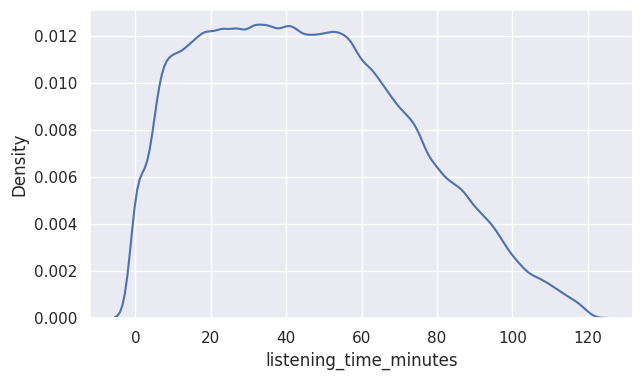

In [11]:
sns.set_theme(rc={'figure.figsize':(7, 4)})
sns.kdeplot(data=train_copy, x=target)

In [12]:
num_columns = list(train_copy._get_numeric_data().columns)
cat_columns = list(set(train_copy.columns) - set(num_columns))

print(num_columns, cat_columns)

['id', 'episode_length_minutes', 'host_popularity_percentage', 'guest_popularity_percentage', 'number_of_ads', 'listening_time_minutes', 'duration_binned'] ['genre', 'publication_day', 'publication_time', 'episode_sentiment', 'podcast_name', 'episode_title']


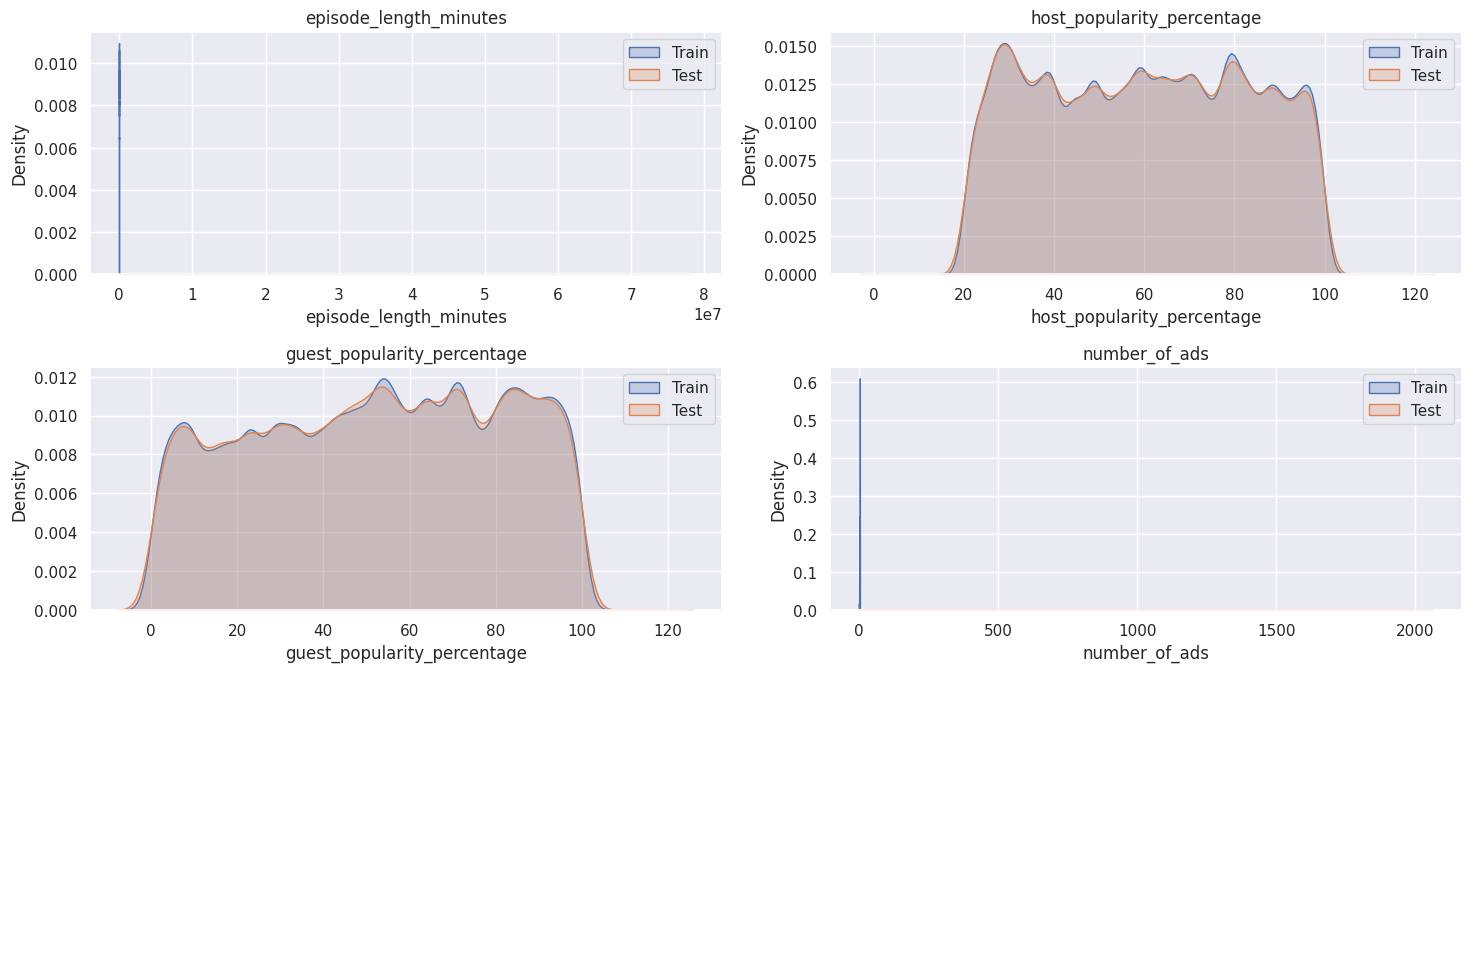

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax = ax.flatten()

i = 0
for col in num_columns:
    if col not in ['id', target, 'duration_binned']:
        sns.kdeplot(data=train_copy, x=col, ax=ax[i], label='Train', fill=True)
        sns.kdeplot(data=test_copy, x=col, ax=ax[i], label='Test', fill=True)
        ax[i].set_title(col)
        ax[i].legend()
        
        i+=1

plt.tight_layout()

for j in range (i, len(ax)):
    ax[j].axis('off')

plt.show()

# Feature engineering

In [14]:
ohe = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
train_cat = ohe.fit_transform(train_df[cat_columns])
test_cat = ohe.transform(test_df[cat_columns])

# Get meaningful column names
encoded_feature_names = ohe.get_feature_names_out(cat_columns)

# Convert encoded data into a DataFrame
encoded_train_df = pd.DataFrame(train_cat, columns=encoded_feature_names, index=train_df.index)
encoded_test_df = pd.DataFrame(test_cat, columns=encoded_feature_names, index=test_df.index)

# Drop original categorical columns and concatenate one-hot encoded columns
train_df_final = pd.concat([train_df.drop(columns=cat_columns), encoded_train_df], axis=1)
test_df_final = pd.concat([test_df.drop(columns=cat_columns), encoded_test_df], axis=1)

show(train_df_final)

,id,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,listening_time_minutes,genre_Business,genre_Comedy,genre_Education,genre_Health,...,episode_title_Episode 90,episode_title_Episode 91,episode_title_Episode 92,episode_title_Episode 93,episode_title_Episode 94,episode_title_Episode 95,episode_title_Episode 96,episode_title_Episode 97,episode_title_Episode 98,episode_title_Episode 99
0,0,NaN,74.81,NaN,0.0,31.41998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,119.80,66.95,75.95,2.0,88.01241,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,73.90,69.97,8.97,0.0,44.92531,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,67.17,57.22,78.70,2.0,46.27824,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,110.51,80.07,58.68,3.0,75.61031,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


750000 rows x 178 columns


# Modeling

In [15]:
train_cols = [i for i in train_df_final.columns if i not in [target, 'id']]
X_train, X_test, y_train, y_test = train_test_split(train_df_final[train_cols], train_df_final[target], test_size=0.33, random_state=42)

In [16]:
model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Score: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Score:  12.91756132840391


In [17]:
print("Score: ", np.sqrt(mean_squared_error(y_test, y_pred)))

Score:  12.91756132840391


# Submission

In [18]:
predictions = model.predict(test_df_final[train_cols])

In [19]:
output = pd.DataFrame.from_dict(data={'id': test_df_final['id'], 'listening_time_minutes': predictions})
show(output)

,id,listening_time_minutes
0,750000,53.596062
1,750001,17.805449
2,750002,48.903088
3,750003,79.076790
4,750004,47.242050


250000 rows x 2 columns


In [20]:
output.to_csv('submission.csv', index=False)